In [2]:
import torch
from torch import tensor
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np

In [3]:
class FairLogReg(nn.Module):
    def __init__(self, D, warm_start = None):
        super(FairLogReg, self).__init__()
        if warm_start is not None:
            self.theta = torch.nn.Parameter(warm_start, requires_grad=True)
        else:
            self.theta = torch.nn.Parameter(torch.zeros(D), requires_grad=True)
        self.old_theta = tensor(float("Inf"))

    def forward(self, x):
        return x.mv(self.theta)


Pick between COMPAS and Adult data sets

In [4]:
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler


def get_adults_datset(n_samples, with_val):
    col_names = [
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "income",
    ]

    # Load data
    data = (
        pd.read_csv("/root/fairclassification/datasets/adult.data", names=col_names)
        .sample(frac=1.0, random_state=42)
        .reset_index(drop=True)
    )

    # Handle missing values
    data = data.replace(" ?", pd.NA)
    data = data.dropna()

    if with_val:
        data = data.iloc[:-5000].copy()

    # Define sensitive attribute
    sensitive_attr = tensor(data['sex'].apply(lambda x: not 'Female' in x).values)
    # data["sex"].apply(lambda x: "Female" in x).values

    # Define target variable
    y = LabelEncoder().fit_transform(data["income"])

    # Define features
    X = data.drop(["sex", "income"], axis=1)

    # Normalization for numeric features
    num_cols = X.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])

    # One-hot encoding for categorical features
    X = pd.get_dummies(X).values
    X = torch.from_numpy(X.astype("float32"))  # Convert to float32 for PyTorch
    y = torch.from_numpy(y.astype("float32"))
    # sensitive_attr = torch.from_numpy(sensitive_attr.astype("long"))
    if not with_val:
        X = X[-5000:, :]
        y = y[-5000:]
        sensitive_attr = sensitive_attr[-5000:]
    return X[:n_samples, :], y[:n_samples], sensitive_attr[:n_samples]


In [5]:
def get_compas_dataset(n_samples, with_val):
    col_names = [
        "sex",
        "age",
        "race",
        "juv_fel_count",
        "juv_misd_count",
        "juv_other_count",
        "priors_count",
        "c_charge_degree",
        "two_year_recid",
    ]

    # Load data
    data = (
        pd.read_csv("/root/fairclassification/datasets/compas-scores-two-years.csv")
        .sample(frac=1.0, random_state=42)
        .reset_index(drop=True)
    )

    data = data.loc[:, col_names]

    # Handle missing values
    data = data.replace(" ?", pd.NA)
    data = data.dropna()

    if with_val:
        data = data.iloc[:-2000].copy()
    else:
        data = data.iloc[-2000:].copy()

    # Define sensitive attribute
    sensitive_attr = tensor(data["race"].apply(lambda x: "African-American" in x).values)

    # Define target variable
    y = LabelEncoder().fit_transform(data["two_year_recid"])

    # Define features
    X = data.drop(["race", "two_year_recid"], axis=1)

    # Normalization for numeric features
    num_cols = X.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])

    # One-hot encoding for categorical features
    X = pd.get_dummies(X).values
    X = torch.from_numpy(X.astype("float32"))  # Convert to float32 for PyTorch
    y = torch.from_numpy(y.astype("float32"))
    return X[:n_samples, :], y[:n_samples], sensitive_attr[:n_samples]

In [6]:
# Comment one out

# def get_data(filename):
#     df = pd.read_csv("data/COMPAS/" + filename + ".csv")
#     s = tensor(df['race'] == "Caucasian")
#     y = tensor(df['two_year_recid'] == 0).float()
#     X = tensor(df.drop(columns=['race','sex','sex-race','two_year_recid']).values).float()
#     X = torch.cat((torch.ones(X.shape[0],1), X), dim=1)
#     return (X,y,s)

# lam_regs = 2. ** np.array([-3, -3, -3, -3, -3])
# lam_regs = 10. ** np.array([-3, -3, -3, -3, -3])
# lam_regs = np.zeros_like(lam_regs)
def get_data(filename):
    df = pd.read_csv("data/Adult/" + filename + ".csv")
    s = tensor(df['sex'] == "Male")
    y = tensor(df['income-per-year'] == ">50K").float()
    X = tensor(df.drop(columns=['sex','race','income-per-year','race-sex','capital-gain', 'capital-loss']).values).float()
    X = torch.cat((torch.ones(X.shape[0],1), X), dim=1)
    return (X,y,s)
lam_regs = 2. ** np.array([-14, -12, -12, -12, -13])

In [28]:
form="logistic"
sum_form=1 # 1 for sum, -1 for difference
unfairness = "eoo"

if unfairness == "eoo":
    eoo=True
    eo=False
elif unfairness == "dp":
    eoo=False
    eo=False
else:
    eoo=False
    eo=True



In [29]:
if form == "logistic":
    def g(outputs):
        return -F.logsigmoid(-outputs).sum()
elif form == "hinge":
    relu = torch.nn.ReLU()
    def g(outputs):
        return relu(outputs+1).sum()
elif form == "linear":
    def g(outputs):
        return outputs.sum()
else:
    raise ValueError("Pick a valid form!")

ploss = nn.BCEWithLogitsLoss()
def floss(outputs, sens_attr, Pa, Pb):
    return sum_form * g(sum_form * outputs[sens_attr])/Pa + g(- outputs[~sens_attr])/Pb

In [30]:
dataset = 'adult'

if dataset == 'compas':
    get_data = get_compas_dataset
elif dataset == 'adult':
    get_data = get_adults_datset

(Xs, ys, ss) = ([None] * 1, [None] * 1, [None] * 1)
(Xts, yts, sts) = ([None] * 1, [None] * 1, [None] * 1)
for i in range(1):
    (Xs[i], ys[i], ss[i]) = get_data(n_samples=50000, with_val=True)
    (Xts[i], yts[i], sts[i]) = get_data(n_samples=1000, with_val=False)

In [31]:
# (Xs, ys, ss) = ([None] * 5, [None] * 5, [None] * 5)
# (Xts, yts, sts) = ([None] * 5, [None] * 5, [None] * 5)
# for i in range(5):
#     (Xs[i], ys[i], ss[i]) = get_data("train" + str(i))
#     (Xts[i], yts[i], sts[i]) = get_data("test" + str(i))

In [32]:
def make_closure(model, optimizer, lam_fair, lam_reg, X, y, s, Pa, Pb):
    def closure():
        assert not torch.isnan(model.theta).any()
        optimizer.zero_grad()
        outputs = model(X)
        if eoo:
            loss = ploss(outputs,y) + lam_reg * (model.theta**2).mean() + lam_fair/outputs.shape[0] * floss(outputs[y.bool()], s[y.bool()], Pa, Pb)
        elif eo:
            loss = ploss(outputs,y) + lam_reg * (model.theta**2).mean() + 0.5*lam_fair/outputs.shape[0] * (floss(outputs[y.bool()], s[y.bool()], Pa[0], Pb[0]) + floss(outputs[~y.bool()], s[~y.bool()], Pa[1], Pb[1]))
        else:
            loss = ploss(outputs,y) + lam_reg * (model.theta**2).mean() + lam_fair/outputs.shape[0] * floss(outputs, s, Pa, Pb)
        loss.backward()
        return loss
    return closure

In [33]:
def train_model(X,y,s,lam_fair=0, lam_reg=0, warm_start=None):
    if eoo:
        (Pa, Pb) = ((s & y.bool()).float().mean(), (~s&y.bool()).float().mean())
    if eo:
        Pa = [(s & y.bool()).float().mean(), (s & ~y.bool()).float().mean()]
        Pb = [(~s & y.bool()).float().mean(), (~s & ~y.bool()).float().mean()]
    else:
        (Pa, Pb) = (s.float().mean(), 1 - s.float().mean())
    model = FairLogReg(X.shape[1], warm_start=warm_start)
    if form == "hingexxx":
        optimizer = optim.Adam(model.parameters(), lr=1)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    else:
        optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
    closure = make_closure(model, optimizer, lam_fair, lam_reg, X, y, s, Pa, Pb)
    for t in trange(500):
        loss = optimizer.step(closure)
        if form == "hingexxx":
            scheduler.step(loss)
        diff = (model.old_theta - model.theta).abs().max()
        if diff < 1e-10:
            break
        model.old_theta = model.theta.clone().detach()
    return (model, t)

In [34]:
def get_summary(model, X,y,s, lam_fair=0, lam_reg=0):
    (Pa, Pb) = (s.float().mean(), 1 - s.float().mean())
    outputs = model(X)
    accuracy = (y == (outputs >= 0)).float().mean()
    if eoo:
        # unfairness = (outputs[y.bool() & s] >= 0).float().mean() - (outputs[y.bool() & ~s] >= 0).float().mean()
        unfairness = (torch.sigmoid(outputs[y.bool() & s])).float().mean() - (torch.sigmoid(outputs[y.bool() & ~s])).float().mean()
        relaxation = 1/outputs.shape[0] * floss(outputs[y.bool()], s[y.bool()], Pa, Pb)
    elif eo:
        unfairness_y1 = 0.5*torch.abs((torch.sigmoid(outputs[y.bool() & s])).float().mean() - (torch.sigmoid(outputs[y.bool() & ~s])).float().mean())
        unfairness_y0 = 0.5*torch.abs((torch.sigmoid(outputs[~y.bool() & s])).float().mean() - (torch.sigmoid(outputs[~y.bool() & ~s])).float().mean())
        # unfairness_y1 = 0.5*torch.abs((outputs[y.bool() & s]>0).float().mean() - (outputs[y.bool() & ~s]>0).float().mean())
        # unfairness_y0 = 0.5*torch.abs((outputs[~y.bool() & s]>0).float().mean() - (outputs[~y.bool() & ~s]>0).float().mean())
        unfairness = unfairness_y0 + unfairness_y1
        relaxation = 1/outputs.shape[0] * floss(outputs[y.bool()], s[y.bool()], Pa, Pb)
    else:
        # unfairness = (torch.sigmoid(outputs[s])).float().mean() - (torch.sigmoid(outputs[~s])).float().mean()
        unfairness = (outputs[s]>0).float().mean() - (outputs[~s]>0).float().mean()
        relaxation = 1/outputs.shape[0] * floss(outputs, s, Pa, Pb)
    loss = ploss(outputs,y)
    return(accuracy, unfairness, loss, relaxation)

In [35]:
# for weighting baseline, if desired
def get_weighed_loss(X,y,s):
    wobs = y * 10 + s
    wobs[wobs==0.] = (wobs==0.).float().mean()
    wobs[wobs==1.] = (wobs==1.).float().mean()
    wobs[wobs==11.] = (wobs==11.).float().mean()
    wobs[wobs==10.] = (wobs==10.).float().mean()
    wy = (y - (y==0).float().mean()).abs()
    ws = (s.float() - (s==0).float().mean()).abs()
    wexp = ws * wy
    return nn.BCEWithLogitsLoss(weight = (wexp/wobs))

In [36]:
sc = ss[0]
print(sc)

tensor([False, False,  True,  ..., False,  True, False])


In [43]:
# df = pd.DataFrame(columns = ['Split', 'Lam_fair', 'Type', 'Accuracy', 'Unfairness', 'Ploss', 'Relaxation'])
warm_starts = [None] * 1
lfs = np.arange(0.1, 2, 0.01) #0.02)
for lam_fair in lfs:
    for i in range(1):
        (model,t) = train_model(Xs[i],ys[i],ss[i], lam_fair = lam_fair, lam_reg = lam_regs[i], warm_start=warm_starts[i])
     #    (model,t) = train_model(Xs[i],ys[i],ss[i], lam_fair = lam_fair, lam_reg = 0, warm_start=warm_starts[i])
        warm_starts[i] = model.theta.clone().detach()
        (train_accuracy, train_unfairness, train_loss, train_relax) = get_summary(model, Xs[i], ys[i], ss[i], lam_fair = lam_fair, lam_reg = lam_regs[i])
        d = {"Split": [i],
             "Type": ["Train"],
             "Lam_fair": [lam_fair.item()],
             'Accuracy': [train_accuracy.item()], 
             'Unfairness': [train_unfairness.item()],
             'Ploss': [train_loss.item()],
             'Relaxation': [train_relax.item()]}
        df = pd.concat([df, pd.DataFrame(d)], axis=0, ignore_index=True)
        (test_accuracy, test_unfairness, test_loss, test_relax) = get_summary(model, Xts[i], yts[i], sts[i], lam_fair = lam_fair, lam_reg = lam_regs[i])
        d = {"Split": [i],
             "Type": ["Test"],
             "Lam_fair": [lam_fair.item()],
             'Accuracy': [test_accuracy.item()], 
             'Unfairness': [test_unfairness.item()],
             'Ploss': [test_loss.item()],
             'Relaxation': [test_relax.item()]}
        df = pd.concat([df, pd.DataFrame(d)], axis=0, ignore_index=True)
    print(lam_fair)


 14%|█▍        | 70/500 [00:02<00:13, 30.85it/s]


0.1


  7%|▋         | 35/500 [00:00<00:06, 77.36it/s]


0.11


  5%|▍         | 23/500 [00:00<00:10, 45.50it/s]


0.12


  5%|▍         | 24/500 [00:00<00:08, 57.33it/s]


0.13


  7%|▋         | 37/500 [00:00<00:07, 64.57it/s]


0.13999999999999999


  4%|▍         | 22/500 [00:00<00:07, 60.20it/s]


0.14999999999999997


  6%|▌         | 29/500 [00:00<00:08, 52.56it/s]


0.15999999999999998


  5%|▌         | 26/500 [00:00<00:07, 67.51it/s]


0.16999999999999998


  4%|▍         | 21/500 [00:00<00:09, 52.00it/s]


0.17999999999999997


  8%|▊         | 39/500 [00:00<00:06, 66.71it/s]


0.18999999999999995


  8%|▊         | 42/500 [00:00<00:05, 83.53it/s]


0.19999999999999996


  6%|▌         | 31/500 [00:00<00:06, 71.09it/s]


0.20999999999999996


  4%|▍         | 22/500 [00:00<00:08, 53.36it/s]


0.21999999999999995


  7%|▋         | 37/500 [00:00<00:06, 74.78it/s]


0.22999999999999995


  4%|▍         | 22/500 [00:00<00:08, 56.98it/s]


0.23999999999999994


  6%|▌         | 28/500 [00:00<00:06, 70.33it/s]


0.24999999999999992


  6%|▌         | 30/500 [00:00<00:06, 67.96it/s]


0.2599999999999999


  5%|▌         | 27/500 [00:00<00:06, 73.63it/s]


0.2699999999999999


  6%|▌         | 28/500 [00:00<00:06, 68.44it/s]


0.2799999999999999


  5%|▌         | 25/500 [00:00<00:07, 60.71it/s]


0.2899999999999999


  5%|▌         | 27/500 [00:00<00:06, 72.47it/s]


0.29999999999999993


  5%|▌         | 25/500 [00:00<00:07, 62.19it/s]


0.30999999999999994


  4%|▍         | 22/500 [00:00<00:08, 58.24it/s]


0.3199999999999999


  6%|▌         | 31/500 [00:00<00:06, 73.83it/s]


0.32999999999999985


  6%|▌         | 30/500 [00:00<00:06, 77.06it/s]


0.33999999999999986


  3%|▎         | 17/500 [00:00<00:07, 62.03it/s]


0.34999999999999987


  5%|▌         | 26/500 [00:00<00:08, 52.91it/s]


0.3599999999999999


  4%|▍         | 22/500 [00:00<00:07, 66.73it/s]


0.3699999999999999


  5%|▌         | 26/500 [00:00<00:06, 71.16it/s]


0.3799999999999999


  5%|▌         | 26/500 [00:00<00:06, 69.17it/s]


0.3899999999999999


  2%|▏         | 11/500 [00:00<00:10, 45.04it/s]


0.3999999999999998


  7%|▋         | 33/500 [00:00<00:05, 80.02it/s]


0.4099999999999998


  3%|▎         | 17/500 [00:00<00:07, 66.30it/s]


0.4199999999999998


  7%|▋         | 35/500 [00:00<00:06, 68.25it/s]


0.4299999999999998


  4%|▍         | 21/500 [00:00<00:07, 66.79it/s]


0.43999999999999984


  5%|▌         | 26/500 [00:00<00:06, 68.98it/s]


0.44999999999999984


  6%|▌         | 28/500 [00:00<00:04, 106.39it/s]


0.45999999999999985


  8%|▊         | 38/500 [00:00<00:05, 88.24it/s]


0.46999999999999986


  4%|▍         | 22/500 [00:00<00:05, 88.22it/s]


0.47999999999999976


 12%|█▏        | 58/500 [00:00<00:04, 98.17it/s] 


0.48999999999999977


  8%|▊         | 40/500 [00:00<00:04, 110.16it/s]


0.4999999999999998


  9%|▉         | 44/500 [00:00<00:04, 111.19it/s]


0.5099999999999998


  5%|▌         | 26/500 [00:00<00:04, 97.05it/s] 


0.5199999999999998


  9%|▊         | 43/500 [00:00<00:04, 92.43it/s]


0.5299999999999998


  4%|▎         | 18/500 [00:00<00:06, 72.31it/s]


0.5399999999999998


 11%|█         | 53/500 [00:00<00:04, 100.41it/s]


0.5499999999999998


  4%|▍         | 19/500 [00:00<00:06, 72.66it/s]


0.5599999999999997


 10%|█         | 51/500 [00:00<00:05, 88.85it/s] 


0.5699999999999997


  7%|▋         | 33/500 [00:00<00:04, 115.12it/s]


0.5799999999999997


  5%|▌         | 27/500 [00:00<00:09, 52.17it/s]


0.5899999999999997


  4%|▍         | 20/500 [00:00<00:19, 24.76it/s]


0.5999999999999998


  7%|▋         | 34/500 [00:01<00:16, 28.02it/s]


0.6099999999999998


  6%|▌         | 28/500 [00:00<00:04, 99.38it/s] 


0.6199999999999998


  9%|▉         | 46/500 [00:00<00:04, 92.11it/s]


0.6299999999999997


  3%|▎         | 16/500 [00:00<00:07, 66.06it/s]


0.6399999999999997


  9%|▉         | 45/500 [00:00<00:04, 96.68it/s] 


0.6499999999999997


  6%|▌         | 31/500 [00:00<00:04, 116.66it/s]


0.6599999999999997


  8%|▊         | 42/500 [00:00<00:05, 88.67it/s]


0.6699999999999997


  4%|▎         | 18/500 [00:00<00:06, 77.36it/s]


0.6799999999999997


 12%|█▏        | 60/500 [00:00<00:04, 99.33it/s] 


0.6899999999999997


  2%|▏         | 12/500 [00:00<00:08, 56.33it/s]


0.6999999999999996


 10%|▉         | 49/500 [00:00<00:04, 102.63it/s]


0.7099999999999996


  4%|▎         | 18/500 [00:00<00:06, 69.76it/s]


0.7199999999999996


  8%|▊         | 40/500 [00:00<00:04, 99.81it/s] 


0.7299999999999996


  4%|▎         | 18/500 [00:00<00:05, 80.94it/s]


0.7399999999999997


 11%|█         | 55/500 [00:00<00:04, 101.51it/s]


0.7499999999999997


  5%|▍         | 23/500 [00:00<00:04, 105.13it/s]


0.7599999999999997


  8%|▊         | 38/500 [00:00<00:05, 87.08it/s]


0.7699999999999997


  4%|▍         | 22/500 [00:00<00:04, 101.66it/s]


0.7799999999999997


  9%|▊         | 43/500 [00:00<00:04, 91.87it/s] 


0.7899999999999996


  4%|▍         | 22/500 [00:00<00:05, 95.21it/s] 


0.7999999999999996


  8%|▊         | 42/500 [00:00<00:04, 95.81it/s] 


0.8099999999999996


  5%|▌         | 27/500 [00:00<00:04, 117.43it/s]


0.8199999999999996


  7%|▋         | 35/500 [00:00<00:05, 85.87it/s]


0.8299999999999996


  5%|▍         | 23/500 [00:00<00:04, 101.72it/s]


0.8399999999999996


 10%|▉         | 48/500 [00:00<00:04, 102.51it/s]


0.8499999999999996


  4%|▍         | 22/500 [00:00<00:04, 102.79it/s]


0.8599999999999995


  7%|▋         | 37/500 [00:00<00:04, 97.68it/s] 


0.8699999999999996


  4%|▎         | 18/500 [00:00<00:05, 89.10it/s]


0.8799999999999996


  8%|▊         | 40/500 [00:00<00:04, 100.60it/s]


0.8899999999999996


  4%|▍         | 21/500 [00:00<00:04, 99.71it/s] 


0.8999999999999996


  8%|▊         | 39/500 [00:00<00:05, 88.83it/s]


0.9099999999999996


  4%|▎         | 18/500 [00:00<00:05, 82.75it/s]


0.9199999999999996


 10%|▉         | 49/500 [00:00<00:03, 117.47it/s]


0.9299999999999996


  3%|▎         | 16/500 [00:00<00:05, 81.99it/s]


0.9399999999999996


  9%|▉         | 46/500 [00:00<00:04, 108.68it/s]


0.9499999999999995


  4%|▎         | 18/500 [00:00<00:05, 89.62it/s]


0.9599999999999995


  8%|▊         | 40/500 [00:00<00:04, 96.20it/s]


0.9699999999999995


  4%|▎         | 18/500 [00:00<00:05, 91.16it/s]


0.9799999999999995


 10%|█         | 51/500 [00:00<00:04, 111.80it/s]


0.9899999999999995


  3%|▎         | 17/500 [00:00<00:05, 86.19it/s]


0.9999999999999996


 10%|▉         | 49/500 [00:00<00:04, 109.32it/s]


1.0099999999999996


  4%|▍         | 21/500 [00:00<00:04, 102.58it/s]


1.0199999999999996


  6%|▌         | 29/500 [00:00<00:04, 103.37it/s]


1.0299999999999996


  8%|▊         | 42/500 [00:00<00:04, 94.18it/s] 


1.0399999999999996


  5%|▍         | 24/500 [00:00<00:04, 110.06it/s]


1.0499999999999996


  9%|▉         | 47/500 [00:00<00:04, 100.25it/s]


1.0599999999999996


  4%|▍         | 22/500 [00:00<00:04, 109.09it/s]


1.0699999999999996


  5%|▌         | 27/500 [00:00<00:04, 97.48it/s]


1.0799999999999996


  8%|▊         | 41/500 [00:00<00:04, 98.70it/s] 


1.0899999999999996


  3%|▎         | 16/500 [00:00<00:05, 80.96it/s]


1.0999999999999996


 12%|█▏        | 62/500 [00:00<00:04, 105.97it/s]


1.1099999999999997


  7%|▋         | 36/500 [00:00<00:05, 86.36it/s]


1.1199999999999997


  3%|▎         | 15/500 [00:00<00:06, 78.71it/s]


1.1299999999999997


  6%|▋         | 32/500 [00:00<00:04, 108.55it/s]


1.1399999999999997


  8%|▊         | 39/500 [00:00<00:07, 64.28it/s]


1.1499999999999995


  4%|▎         | 18/500 [00:00<00:05, 80.69it/s]


1.1599999999999995


  8%|▊         | 38/500 [00:00<00:04, 108.60it/s]


1.1699999999999995


  4%|▍         | 21/500 [00:00<00:04, 98.66it/s] 


1.1799999999999995


  8%|▊         | 41/500 [00:00<00:04, 94.81it/s] 


1.1899999999999995


  2%|▏         | 11/500 [00:00<00:07, 61.87it/s]


1.1999999999999995


  7%|▋         | 37/500 [00:00<00:04, 99.09it/s] 


1.2099999999999995


  8%|▊         | 42/500 [00:00<00:05, 89.24it/s] 


1.2199999999999995


  4%|▍         | 22/500 [00:00<00:04, 105.99it/s]


1.2299999999999995


  8%|▊         | 38/500 [00:00<00:03, 118.86it/s]


1.2399999999999995


 11%|█         | 55/500 [00:00<00:04, 93.76it/s] 


1.2499999999999996


  5%|▌         | 26/500 [00:00<00:03, 124.53it/s]


1.2599999999999996


  4%|▍         | 21/500 [00:00<00:05, 84.91it/s]


1.2699999999999996


  8%|▊         | 40/500 [00:00<00:04, 97.40it/s]


1.2799999999999996


  3%|▎         | 16/500 [00:00<00:06, 79.51it/s]


1.2899999999999996


  5%|▌         | 25/500 [00:00<00:04, 98.25it/s] 


1.2999999999999994


  7%|▋         | 34/500 [00:00<00:07, 62.08it/s]


1.3099999999999994


  4%|▎         | 18/500 [00:00<00:05, 95.31it/s]


1.3199999999999994


  4%|▍         | 20/500 [00:00<00:06, 79.11it/s]


1.3299999999999994


  8%|▊         | 40/500 [00:00<00:06, 74.15it/s]


1.3399999999999994


  4%|▍         | 19/500 [00:00<00:07, 62.75it/s]


1.3499999999999994


  4%|▍         | 20/500 [00:00<00:05, 83.04it/s]


1.3599999999999994


  7%|▋         | 33/500 [00:00<00:05, 83.81it/s]


1.3699999999999994


  4%|▍         | 20/500 [00:00<00:05, 95.86it/s] 


1.3799999999999994


  4%|▎         | 18/500 [00:00<00:05, 80.58it/s]


1.3899999999999995


  9%|▊         | 43/500 [00:00<00:04, 93.05it/s]


1.3999999999999995


  4%|▎         | 18/500 [00:00<00:05, 91.17it/s]


1.4099999999999995


  5%|▍         | 24/500 [00:00<00:04, 98.59it/s] 


1.4199999999999995


  8%|▊         | 42/500 [00:00<00:04, 103.31it/s]


1.4299999999999995


  5%|▍         | 24/500 [00:00<00:04, 118.21it/s]


1.4399999999999995


  6%|▌         | 30/500 [00:00<00:03, 122.69it/s]


1.4499999999999995


  9%|▊         | 43/500 [00:00<00:04, 99.37it/s] 


1.4599999999999995


  3%|▎         | 16/500 [00:00<00:16, 29.71it/s]


1.4699999999999993


  5%|▌         | 25/500 [00:00<00:09, 47.99it/s]


1.4799999999999993


 11%|█         | 56/500 [00:00<00:05, 87.11it/s] 


1.4899999999999993


  5%|▍         | 23/500 [00:00<00:06, 77.29it/s]


1.4999999999999993


  7%|▋         | 34/500 [00:00<00:07, 64.86it/s]


1.5099999999999993


  4%|▍         | 20/500 [00:00<00:06, 77.37it/s]


1.5199999999999994


  3%|▎         | 17/500 [00:00<00:06, 71.74it/s]


1.5299999999999994


  8%|▊         | 40/500 [00:00<00:04, 96.05it/s] 


1.5399999999999994


  4%|▍         | 20/500 [00:00<00:04, 100.29it/s]


1.5499999999999994


  5%|▍         | 23/500 [00:00<00:05, 95.25it/s]


1.5599999999999994


 10%|█         | 51/500 [00:00<00:05, 80.93it/s] 


1.5699999999999994


  4%|▍         | 19/500 [00:00<00:04, 104.34it/s]


1.5799999999999994


  4%|▍         | 19/500 [00:00<00:05, 80.77it/s]


1.5899999999999994


  9%|▉         | 46/500 [00:00<00:04, 95.36it/s] 


1.5999999999999994


  5%|▍         | 24/500 [00:00<00:04, 118.26it/s]


1.6099999999999994


  4%|▍         | 20/500 [00:00<00:05, 82.00it/s]


1.6199999999999992


  7%|▋         | 35/500 [00:00<00:05, 91.16it/s]


1.6299999999999992


  4%|▍         | 19/500 [00:00<00:04, 100.03it/s]


1.6399999999999992


  5%|▍         | 23/500 [00:00<00:04, 98.19it/s] 


1.6499999999999992


  8%|▊         | 39/500 [00:00<00:04, 94.08it/s] 


1.6599999999999993


  4%|▍         | 19/500 [00:00<00:04, 101.02it/s]


1.6699999999999993


  4%|▍         | 19/500 [00:00<00:05, 92.01it/s]


1.6799999999999993


  7%|▋         | 37/500 [00:00<00:06, 76.93it/s] 


1.6899999999999993


  4%|▍         | 19/500 [00:00<00:04, 97.30it/s] 


1.6999999999999993


  5%|▍         | 23/500 [00:00<00:04, 96.06it/s]


1.7099999999999993


  9%|▉         | 47/500 [00:00<00:03, 115.96it/s]


1.7199999999999993


  4%|▎         | 18/500 [00:00<00:04, 105.33it/s]


1.7299999999999993


  4%|▍         | 21/500 [00:00<00:04, 96.98it/s] 


1.7399999999999993


 10%|█         | 51/500 [00:00<00:05, 88.67it/s] 


1.7499999999999993


  5%|▌         | 27/500 [00:00<00:03, 124.88it/s]


1.7599999999999993


  6%|▌         | 31/500 [00:00<00:04, 104.77it/s]


1.7699999999999994


 10%|▉         | 48/500 [00:00<00:03, 126.90it/s]


1.7799999999999994


  4%|▍         | 21/500 [00:00<00:04, 111.30it/s]


1.7899999999999991


  4%|▍         | 21/500 [00:00<00:04, 98.89it/s] 


1.7999999999999992


  8%|▊         | 41/500 [00:00<00:04, 105.25it/s]


1.8099999999999992


  3%|▎         | 14/500 [00:00<00:06, 79.85it/s]


1.8199999999999992


  4%|▍         | 19/500 [00:00<00:05, 87.18it/s]


1.8299999999999992


 10%|█         | 52/500 [00:00<00:03, 112.61it/s]


1.8399999999999992


  4%|▍         | 20/500 [00:00<00:06, 76.96it/s]


1.8499999999999992


  4%|▍         | 19/500 [00:00<00:08, 56.26it/s]


1.8599999999999992


  9%|▉         | 45/500 [00:00<00:07, 57.35it/s]


1.8699999999999992


  4%|▎         | 18/500 [00:00<00:04, 100.92it/s]


1.8799999999999992


  5%|▌         | 27/500 [00:00<00:03, 122.74it/s]


1.8899999999999992


 10%|█         | 51/500 [00:00<00:04, 95.17it/s] 


1.8999999999999992


  6%|▌         | 29/500 [00:00<00:04, 108.57it/s]


1.9099999999999993


  7%|▋         | 33/500 [00:00<00:06, 71.39it/s]


1.9199999999999993


  4%|▍         | 21/500 [00:00<00:04, 115.38it/s]


1.9299999999999993


  3%|▎         | 17/500 [00:00<00:07, 63.27it/s]


1.939999999999999


 10%|▉         | 49/500 [00:00<00:06, 71.73it/s]


1.949999999999999


  4%|▍         | 21/500 [00:00<00:04, 108.14it/s]


1.959999999999999


  3%|▎         | 16/500 [00:00<00:05, 83.29it/s]


1.969999999999999


  8%|▊         | 42/500 [00:00<00:05, 84.01it/s] 


1.979999999999999


  3%|▎         | 15/500 [00:00<00:05, 86.53it/s]

1.989999999999999


In [38]:
df

,Split,Lam_fair,Type,Accuracy,Unfairness,Ploss,Relaxation
0,0,0.000,Train,0.849773,0.058753,0.325463,0.718337
1,0,0.000,Test,0.855000,-0.013011,0.311903,0.625794
2,0,0.001,Train,0.849813,0.058152,0.325465,0.713470
3,0,0.001,Test,0.855000,-0.013469,0.311992,0.621900
4,0,0.002,Train,0.849813,0.057552,0.325475,0.708437
...,...,...,...,...,...,...,...
195,0,0.097,Test,0.847000,-0.049581,0.327222,0.422867
196,0,0.098,Train,0.842938,0.001925,0.335574,0.459473
197,0,0.098,Test,0.847000,-0.049914,0.327404,0.421737
198,0,0.099,Train,0.842779,0.001344,0.335718,0.458018


In [44]:
# df = pd.read_csv("./adult_dp_results.csv")
df_0 = df.loc[(df['Split']==0) & (df['Type']=='Test')].copy()


In [45]:
df_0['Unfairness'] = np.abs(df_0['Unfairness'])

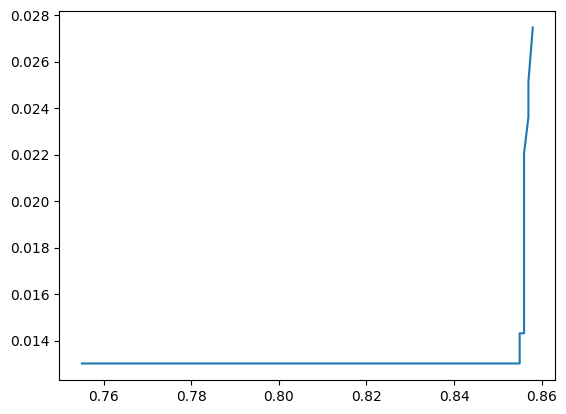

In [46]:
import matplotlib.pyplot as plt

df_0 = df_0.sort_values(by='Accuracy')
unfairness_vals = df_0['Unfairness'].values
min_unfairness = [np.min(unfairness_vals[i:]) for i in range(len(unfairness_vals))]
plt.plot(df_0['Accuracy'], min_unfairness)




In [42]:
# df.to_csv("./adult_dp_results.csv")
df_0['min_unfairness_vals'] = min_unfairness
df_0.to_csv("./adult_eop_preprocessed_logistic.csv", index=False)

In [1]:
Xts[0].shape

NameError: name 'Xts' is not defined